# Active Ranking from Pairwise Comparisons and when Parametric Assumptions Don’t Help

We consider sequential or active ranking of a set of n items based on noisy pairwise compar- isons. Items are ranked according to the probability that a given item beats a randomly chosen item, and ranking refers to partitioning the items into sets of pre-specified sizes according to their scores. This notion of ranking includes as special cases the identification of the top-$k$ items and the total ordering of the items. For simplicity, let us consider the top-$k$ identification problem.

We consider a collection of $n$ items, and our data consists
of outcomes of comparisons between pairs of items in this collection
that are collected in a sequential fashion, also known as the active
setting. We assume that the outcomes of comparisons are
stochastic---that is, item $i$ beats item $j$ with an unknown
probability $M_{ij} \in (0,1)$. The outcomes of pairwise
comparisons are furthermore assumed to be statistically mutually
independent. We define the ordering of the items in terms of their
(unknown) scores, where the score $\tau_i$ of item $i$ is defined as
the probability that item $i$ beats an item chosen uniformly at random
from all other items:
$$
\tau_i := \frac{1}{n - 1} \sum_{j\neq i} M_{ij}.
$$
Assuming that the scores are all distinct, they define a unique ranking of the $n$ items. Identifying the top-$k$ items amounts to identify two disjoint subsets $\hat S_1, \hat S_2 \subset \{1,\ldots,n\}$ such that all items in $\hat S_1$ have a larger score than the items in the set $\hat S_2$. 

An active ranking algorithm acts on a pairwise comparison model $M$. The goal is to identify the top-$k$ items from active comparisons.  At each time
instant, the algorithm can compare two arbitrary items, and the choice
of which items to compare may be based on the outcomes of previous
comparisons. As a result of comparing two items $i$ and $j$, the
algorithm receives an independent draw of a binary random variable
with success probability $M_{ij}$ in response.  After termination
dictated by an associated stopping rule, the algorithm returns a
ranking $\hat S_1, \hat S_2$.

## The model
We start with defining a class for representing a pairwise comparision model.

In [105]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib inline

class pairwise:
    def __init__(self,n):
        self.ctr = 0 # counts how many comparisons have been queried from the model
        self.n = n 

    def sortP(self): # sort the comparison matrix according to scores
        scores = self.scores()
        pi = argsort(-scores)
        self.P = self.P[:,pi]
        self.P = self.P[pi,:]
    
    def generate_deterministic_BTL(self,w): # generates a Bradley-Terry-Luce model
        self.w = w
        self.P = zeros((self.n,self.n))
        for i in range(self.n):
            for j in range(i,self.n):
                self.P[i,j] = 1/( 1 + exp( w[j] - w[i] ) )
                self.P[j,i] = 1 - self.P[i,j]
        self.sortP()

    def compare(self,i,j): # draw a comparision from the model
        if i == j:
            print("does not make sense")
        self.ctr += 1
        if random.rand() < self.P[i,j]:
            return 1 # i beats j
        else:
            return 0 # j beats i

    def scores(self):
        P = array(self.P)
        for i in range(len(P)):
            P[i,i] = 0
        return sum(P,axis=1)/(self.n-1)
    
    def topk_complexity(self,k=1):
        sc = self.scores();
        lower = sum([ 1/(sc[k-1]-sc[i])**2 for i in range(k,self.n)])
        upper = sum([ 1/(sc[i]-sc[k])**2 for i in range(0,k)])
        return lower + upper

Let us next generate a small BTL model, and test it.

In [115]:
n = 5
delta = 0.1
pmodel = pairwise(n)
pmodel.generate_deterministic_BTL([ i/float(n) for i in range(n) ])

print("The pairwise comparison probabilities are:\n", pmodel.P, "\n")

print("The scores of the items are:\n", pmodel.scores(),"\n")

# make a few comparisions
for i in range(5): 
    print("Comparing 1 to 2 gives:", '1 wins' if pmodel.compare(1,2) else '2 wins')
    
print(pmodel.ctr, " queries have been made")

The pairwise comparison probabilities are:
 [[ 0.5         0.549834    0.59868766  0.64565631  0.68997448]
 [ 0.450166    0.5         0.549834    0.59868766  0.64565631]
 [ 0.40131234  0.450166    0.5         0.549834    0.59868766]
 [ 0.35434369  0.40131234  0.450166    0.5         0.549834  ]
 [ 0.31002552  0.35434369  0.40131234  0.450166    0.5       ]] 

The scores of the items are:
 [ 0.62103811  0.56108599  0.5         0.43891401  0.37896189] 

Comparing 1 to 2 gives: 2 wins
Comparing 1 to 2 gives: 1 wins
Comparing 1 to 2 gives: 1 wins
Comparing 1 to 2 gives: 2 wins
Comparing 1 to 2 gives: 2 wins
5  queries have been made


## The ranking algorithm
Let us next implement the randing algorithm. The algorithm in our paper uses an elimination strategy - below we implement a variant of our algorithm that is based on the LUCB (lower upper confidence bound) strategy from the bandit literature. Both algorithms share the same guarantees on the sample complexity.

In [116]:
class LUCB_ranking:
    def __init__(self,pairwise,k):
        self.k = k
        self.pairwise = pairwise # instance of pairwise
        self.pairwise.ctr = 0 # number of random comparisons made

    def random_cmp(self,i): # compare i to randomly choosen other item
        j = random.choice(range(self.pairwise.n-1))
        if j >= i:
            j += 1
        return float( self.pairwise.compare(i,j) )

    def alpha(self,Ti): # confidence interval
        n = self.pairwise.n
        beta = log(n/self.delta) + 0.75*log(log(n/self.delta)) + 1.5*log(1+log(Ti/2))
        return sqrt( 3 / (2*Ti) ) 

    def rank(self,delta=0.1,numit = 6000000):
        self.delta = delta
        S = [] # list with entries ( i, T_i, scorehat_i, scorehat_i - alpha_i, scorehat_i + alpha_i, alpha_i)
        # compare each item once to initialize
        for i in range(self.pairwise.n):
            scorehat = self.random_cmp(i)
            S.append( ( i, 1, scorehat, scorehat-self.alpha(1), scorehat+self.alpha(1), self.alpha(1) ) )
            
        for iit in range(numit):
            # sort descending by score ('entry' has fields (i, T_i, scorehat_i,...)
            S = sorted(S , key=lambda entry: entry[2],reverse=True)
            # min scorehat_i - alpha_i; min over (1),...,(k)
            d1low = min( S[:self.k] , key=lambda entry: entry[3] )
            # max scorehat_i + alpha_i; max over (k+1),...,(n)
            d2up = max( S[self.k:] , key=lambda entry: entry[4] )

            if d1low[3] > d2up[4]: # termination condition
                break # terminate

            for it in [d1low,d2up]: # items to sample in next round
                Ti = it[1] + 1
                shat = 1.0/Ti*( (Ti-1)*it[2] + self.random_cmp( it[0] ) )
                alphai = self.alpha(Ti)
                S[S.index(it)] = ( it[0], Ti, shat, shat - alphai, shat + alphai, alphai )
        self.S = S
        estimated_ranking = [s[0] for s in S]
        self.ranking = [ estimated_ranking[:self.k], estimated_ranking[self.k:]  ]

    def plot_scores(self): # plot 
        n = len(self.S)
        scorehat = [self.S[i][2] for i in range(n)]
        upperest = [self.S[i][3] for i in range(n)]
        lowerest = [self.S[i][4] for i in range(n)]
        plt.plot(range(n),scorehat, 'rx',range(n),upperest, 'bx',range(n),lowerest, 'yx' )
        plt.show()
        
    def evaluate_perfect_recovery(self): # did it suceed?
        return set(self.ranking[0]) == set([i for i in range(self.k)])


Let's run the algorithm on our example, for $k=2$:

The top-k items are:  [0, 1]
The algorithm did succeed :)
It required  1939  many comparisons.

Confidence intervals at termination (red is the estimate, yellow and blue are the lower and upper confidence bounds):


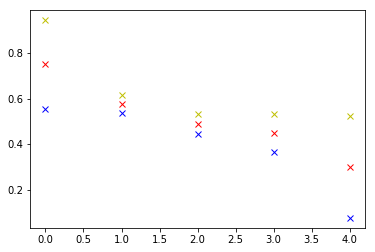

In [117]:
k = 2
delta = 0.1
alg = LUCB_ranking(pmodel,k)
alg.rank(0.1)
print("The top-k items are: ", alg.ranking[0])
print("The algorithm did", "succeed :)" if alg.evaluate_perfect_recovery() else "not succeed :(")
print("It required ", alg.pairwise.ctr, " many comparisons.\n")
print("Confidence intervals at termination (red is the estimate, yellow and blue are the lower and upper confidence bounds):")
alg.plot_scores()

# The theory

Accordign to our theory, the sample complexity for scores 
$\tau_1 > \tau_2 > \ldots \tau_n$ 
is (up to log-factors) given by:
$$
H(M) = \sum_{i=1}^k \frac{1}{(\tau_i - \tau_{k+1})^2}
+
\sum_{i=k+1}^{n} \frac{1}{(\tau_k - \tau_{i})^2}.
$$
Let's verify this with a simple experiment. We generate models with different parameters, and see whether the ratio of the empirical sample complexity over $H(M)$ is approximately constant:

In [137]:
numit = 40
k = 1
delta = 0.1

for n in range(4,10):
    pmodel = pairwise(n)
    w = [ i/float(n) for i in range(n) ] #w = random.rand(n)+0.1
    pmodel.generate_deterministic_BTL(w)
    print("H(M): ", pmodel.topk_complexity(k))
    alg = LUCB_ranking(pmodel,k)
    su = 0
    for i in range(numit):
        alg.pairwise.ctr = 0
        alg.rank(0.1)
        su += alg.pairwise.ctr / alg.pairwise.topk_complexity() / numit 
    print("empirical sample complexity / H(M):", su, "\n")

H(M):  364.060505465
empirical sample complexity / H(M): 4.50254827258 

H(M):  671.914678452
empirical sample complexity / H(M): 4.73512501219 

H(M):  1076.66591004
empirical sample complexity / H(M): 4.70354819707 

H(M):  1578.91054253
empirical sample complexity / H(M): 4.74646903555 

H(M):  2179.01141861
empirical sample complexity / H(M): 4.03006148797 

H(M):  2877.20736974
empirical sample complexity / H(M): 4.2545768959 

